# Appendix-N: Chained In-Context Learning (INCORRECT Anchoring)

## The "Exponentiation of Error" Test

**Background:** EXPT 15a (Structural ICL) showed modest benefits for simple A→B pairs at γ=0.2. To achieve statistically significant separation, we need a harder task.

---

## The Chain Reaction Hypothesis

**Standard Transformer (Baseline):**
- To solve a chain `A→B→C→...→Z`, the model must learn L independent induction heads
- If success probability per link is `p < 1`, chain success = `p^L` (exponential crash)

**Momentum Transformer:**
- Kinematic momentum `p_t` connects the sequence physically
- Once `A→B` is recognized, momentum vector naturally "points" to next state
- Hypothesis: Reduces effective decay rate, rescues model on long chains

---

**⚠️ NOTE: This notebook uses INCORRECT ANCHORING (no special anchor token)**
- This demonstrates context mismatch - momentum vectors differ between lesson and query
- Expected result: Momentum will FAIL or show minimal/negative improvement
- Compare with companion notebook with CORRECT anchoring

---

**Task:** Multi-Hop In-Context Retrieval
- Chain Length: L = 10 (the "crash threshold")
- Pattern: `A→B→C→D→...→J` embedded in context with distractors
- Query: Given segment start (e.g., "C"), predict next link ("D")

**Hardware Target:** Google Colab A100 (40GB)

## 0. Colab Setup

In [1]:
# Colab-specific setup
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
else:
    print("Running locally (GB10 or other)")

Running in Google Colab


## 1. Imports and Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List
import json
import os
from datetime import datetime
import math

# Handle tqdm for both Colab and local
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## 2. Configuration

In [3]:
@dataclass
class ExperimentConfig:
    """Configuration for EXPT 15b: Chained ICL (Multi-Hop Retrieval) - INCORRECT ANCHORING"""

    # Model Architecture (TinyLlama-style)
    vocab_size: int = 1000
    d_model: int = 256
    n_layers: int = 4
    n_heads: int = 8
    d_head: int = 32  # d_model // n_heads
    d_ff: int = 1024  # 4 * d_model
    max_seq_len: int = 512
    dropout: float = 0.1

    # RoPE Configuration
    rope_base: float = 10000.0

    # Momentum Configuration
    gamma: float = 0.2  # "Sweet spot" from EXPT 15a
    beta: float = 0.0   # No EMA smoothing

    # Chained ICL Dataset Configuration (NO ANCHORING - INCORRECT)
    seq_length: int = 512
    chain_length: int = 10     # L = 10 (the "crash threshold")
    num_chains: int = 4        # Number of distinct chains per sequence
    chain_insert_prob: float = 0.4   # P(insert full chain)
    query_insert_prob: float = 0.4   # P(insert query chunk)
    # Remaining 0.2 = noise

    # Training Configuration
    batch_size: int = 32
    n_train_steps: int = 10000
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_steps: int = 500
    eval_every: int = 500

    # Experiment
    experiment_name: str = "expt15b_chained_icl_no_anchor"
    save_dir: str = "./expt15b_results"

config = ExperimentConfig()
os.makedirs(config.save_dir, exist_ok=True)

print(f"Experiment: {config.experiment_name}")
print(f"Model: d={config.d_model}, L={config.n_layers}, H={config.n_heads}")
print(f"Momentum: γ={config.gamma}, β={config.beta}")
print(f"Chain Length: {config.chain_length} (the 'crash threshold')")
print(f"Training: {config.n_train_steps} steps, batch={config.batch_size}")
print(f"\n⚠️ WARNING: Using INCORRECT anchoring (no special anchor token)")

Experiment: expt15b_chained_icl_no_anchor
Model: d=256, L=4, H=8
Momentum: γ=0.2, β=0.0
Chain Length: 10 (the 'crash threshold')
Training: 10000 steps, batch=32

⚠️ WARNING: Using INCORRECT anchoring (no special anchor token)


## 3. Chained ICL Dataset (WITHOUT Anchoring)

**Key Design:**
- Generate chains of length L=10: `A→B→C→D→E→F→G→H→I→J`
- **NO ANCHOR TOKEN** - chains start directly with content tokens
- Interleave: Full chains ("lessons"), Query chunks ("tests"), Noise ("distractions")
- Model must learn to continue chains from any starting point

**Expected Problem:**
- Momentum vector at token A depends on what came BEFORE A
- In lesson: momentum = A - (previous_token_in_lesson)
- In query: momentum = A - (previous_token_in_query)
- These differ → Context Mismatch → Momentum fails!

In [4]:
class ChainedICLDataset(Dataset):
    """
    Generates sequences with LONG ASSOCIATIVE CHAINS (Multi-Hop).

    Structure: A→B→C→D→...→J (Length 10) - NO ANCHOR TOKEN

    This version demonstrates the CONTEXT MISMATCH problem:
    - Without anchoring, momentum vectors differ between lesson and query
    - Expected: Momentum will fail to help (or hurt performance)
    """

    def __init__(self, config: ExperimentConfig, n_samples: int = 10000):
        self.config = config
        self.n_samples = n_samples
        self.chain_length = config.chain_length

        # Pre-generate all sequences
        self.sequences = self._generate_all_sequences()

    def _generate_all_sequences(self) -> torch.Tensor:
        """Generate all sequences upfront for consistent evaluation."""
        sequences = []
        for _ in range(self.n_samples):
            seq = self._generate_single_sequence()
            sequences.append(seq)
        return torch.stack(sequences)

    def _generate_single_sequence(self) -> torch.Tensor:
        """
        Generate a sequence with interleaved chains, queries, and noise.

        Structure (WITHOUT ANCHOR):
        - FULL CHAIN: "A→B→C→D→..." (the "lesson") - NO anchor prefix
        - QUERY: "C..." (model must predict D, E, F...) (the "test")
        - NOISE: Random tokens (the "distraction")
        """
        cfg = self.config
        final_seq = []

        # 1. Create a pool of chains (unique per sequence)
        chains = []
        for _ in range(cfg.num_chains):
            # Sample unique tokens for this chain (NO ANCHOR)
            chain = np.random.choice(
                cfg.vocab_size,
                size=self.chain_length,
                replace=False
            )
            chains.append(chain)

        # 2. Construct the stream (interleaved)
        target_len = cfg.seq_length

        while len(final_seq) < target_len:
            r = np.random.random()

            if r < cfg.chain_insert_prob:
                # INSERT FULL CHAIN (The "Lesson") - NO ANCHOR
                which_chain = chains[np.random.randint(0, cfg.num_chains)]
                final_seq.extend(which_chain.tolist())

            elif r < cfg.chain_insert_prob + cfg.query_insert_prob:
                # INSERT QUERY (The "Test") - NO ANCHOR
                which_chain = chains[np.random.randint(0, cfg.num_chains)]

                # Start from a random position in the chain
                start = np.random.randint(0, self.chain_length - 1)

                # Provide a chunk of the chain (variable length for diversity)
                chunk_len = np.random.randint(2, min(5, self.chain_length - start) + 1)
                chunk = which_chain[start:start + chunk_len]
                final_seq.extend(chunk.tolist())

            else:
                # INSERT NOISE (The "Distraction")
                noise_len = np.random.randint(5, 20)
                noise = np.random.randint(0, cfg.vocab_size, size=noise_len)
                final_seq.extend(noise.tolist())

        # Truncate to exact sequence length
        return torch.tensor(final_seq[:target_len], dtype=torch.long)

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sequences[idx]


# Test the dataset
print("Testing Chained ICL Dataset (NO ANCHORING)...")
test_dataset = ChainedICLDataset(config, n_samples=100)
sample = test_dataset[0]
print(f"Sample sequence shape: {sample.shape}")
print(f"First 60 tokens: {sample[:60].tolist()}")

# Analyze chain structure
tokens = sample.tolist()
unique_tokens = len(set(tokens))
print(f"\nUnique tokens: {unique_tokens} / {len(tokens)}")
print(f"Token repetition: {1 - unique_tokens/len(tokens):.1%}")

Testing Chained ICL Dataset (NO ANCHORING)...
Sample sequence shape: torch.Size([512])
First 60 tokens: [211, 196, 803, 331, 138, 356, 600, 273, 18, 982, 310, 869, 885, 977, 153, 389, 259, 619, 882, 796, 570, 521, 737, 740, 660, 411, 678, 626, 513, 859, 136, 847, 449, 929, 246, 519, 140, 361, 7, 477, 612, 468, 355, 586, 586, 938, 983, 602, 209, 678, 626, 513, 859, 136, 93, 692, 100, 562, 729, 924]

Unique tokens: 166 / 512
Token repetition: 67.6%


## 4. Rotary Position Embedding (RoPE)

**Critical:** RoPE applied ONLY to position coordinates, not to momentum.

In [5]:
class RotaryPositionEmbedding(nn.Module):
    """
    Rotary Position Embedding (RoPE).

    Applied ONCE to create position coordinates q_t.
    Momentum p_t = q_t - q_{t-1} is computed AFTER RoPE.
    """

    def __init__(self, d_head: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.d_head = d_head
        self.max_seq_len = max_seq_len
        self.base = base

        inv_freq = 1.0 / (base ** (torch.arange(0, d_head, 2).float() / d_head))
        self.register_buffer('inv_freq', inv_freq)
        self._precompute_cache(max_seq_len)

    def _precompute_cache(self, seq_len: int):
        t = torch.arange(seq_len, device=self.inv_freq.device).float()
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())

    def _rotate_half(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[..., :x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2:]
        return torch.cat([-x2, x1], dim=-1)

    def forward(self, x: torch.Tensor, seq_len: int = None) -> torch.Tensor:
        if seq_len is None:
            seq_len = x.shape[2]
        cos = self.cos_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        sin = self.sin_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        return (x * cos) + (self._rotate_half(x) * sin)

print("RoPE module defined ✓")

RoPE module defined ✓


## 5. Momentum-Augmented Multi-Head Attention

**Architecture (from paper):**
1. SHARED weight matrices for Q, K, V
2. RoPE applied ONCE to position coordinates
3. Momentum = `q_t - q_{t-1}` (AFTER RoPE)
4. Augmentation: `q̃_t = q_t + γ·p_t`

In [6]:
class MomentumMultiHeadAttention(nn.Module):
    """
    Momentum-Augmented Multi-Head Attention.

    Key insight for CHAINED ICL:
    - Once A→B is recognized, momentum vector p ≈ B-A
    - This "velocity" helps the model slide down the chain
    - Expected: Better performance on deep links (H→I, I→J)

    BUT WITHOUT ANCHORING:
    - Momentum at A in lesson ≠ momentum at A in query
    - Context mismatch destroys the guide-rail effect
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_head: int,
        dropout: float = 0.1,
        max_seq_len: int = 2048,
        rope_base: float = 10000.0,
        gamma: float = 0.0,
        beta: float = 0.0,
    ):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.gamma = gamma
        self.beta = beta
        self.scale = 1.0 / math.sqrt(d_head)

        # SHARED weight matrices
        self.W_q = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_k = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_v = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_o = nn.Linear(n_heads * d_head, d_model, bias=False)

        # RoPE (applied ONCE)
        self.rope = RotaryPositionEmbedding(d_head, max_seq_len, rope_base)
        self.dropout = nn.Dropout(dropout)

    def _compute_momentum(self, x: torch.Tensor) -> torch.Tensor:
        """Kinematic momentum: p_t = q_t - q_{t-1}"""
        momentum = torch.zeros_like(x)
        momentum[:, :, 1:, :] = x[:, :, 1:, :] - x[:, :, :-1, :]

        if self.beta > 0:
            smoothed = torch.zeros_like(momentum)
            smoothed[:, :, 0, :] = momentum[:, :, 0, :]
            for t in range(1, momentum.shape[2]):
                smoothed[:, :, t, :] = (
                    self.beta * smoothed[:, :, t-1, :] +
                    (1 - self.beta) * momentum[:, :, t, :]
                )
            momentum = smoothed

        return momentum

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        batch_size, seq_len, _ = x.shape

        # Project
        q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        k = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)
        v = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_head).transpose(1, 2)

        # Apply RoPE ONCE
        q_pos = self.rope(q, seq_len)
        k_pos = self.rope(k, seq_len)

        # Compute momentum AFTER RoPE and augment
        if self.gamma > 0:
            p_q = self._compute_momentum(q_pos)
            p_k = self._compute_momentum(k_pos)
            q_aug = q_pos + self.gamma * p_q
            k_aug = k_pos + self.gamma * p_k
        else:
            q_aug = q_pos
            k_aug = k_pos

        # Attention
        attn_scores = torch.matmul(q_aug, k_aug.transpose(-2, -1)) * self.scale

        if attention_mask is None:
            causal_mask = torch.triu(
                torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
                diagonal=1
            )
            attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))
        else:
            attn_scores = attn_scores.masked_fill(attention_mask, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.W_o(output)

        return output, attn_weights

print("Momentum Attention module defined ✓")

Momentum Attention module defined ✓


## 6. Full Transformer Model

In [7]:
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight


class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


class TransformerBlock(nn.Module):
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.norm1 = RMSNorm(config.d_model)
        self.attn = MomentumMultiHeadAttention(
            d_model=config.d_model,
            n_heads=config.n_heads,
            d_head=config.d_head,
            dropout=config.dropout,
            max_seq_len=config.max_seq_len,
            rope_base=config.rope_base,
            gamma=gamma,
            beta=config.beta,
        )
        self.norm2 = RMSNorm(config.d_model)
        self.ff = FeedForward(config.d_model, config.d_ff, config.dropout)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        h, attn_weights = self.attn(self.norm1(x), attention_mask)
        x = x + h
        x = x + self.ff(self.norm2(x))
        return x, attn_weights


class MomentumTransformer(nn.Module):
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.config = config
        self.gamma = gamma

        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(config, gamma=gamma)
            for _ in range(config.n_layers)
        ])
        self.norm = RMSNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        self.lm_head.weight = self.token_emb.weight  # Tie embeddings

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids: torch.Tensor, return_attention: bool = False):
        x = self.token_emb(input_ids)
        all_attention = []
        for block in self.blocks:
            x, attn_weights = block(x)
            if return_attention:
                all_attention.append(attn_weights)
        x = self.norm(x)
        logits = self.lm_head(x)
        output = {'logits': logits}
        if return_attention:
            output['attention_weights'] = all_attention
        return output

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test model
print("Testing Model...")
model_test = MomentumTransformer(config, gamma=config.gamma).to(device)
print(f"Parameters: {model_test.count_parameters():,}")

test_ids = torch.randint(0, config.vocab_size, (2, 64)).to(device)
output = model_test(test_ids)
print(f"Logits: {output['logits'].shape} ✓")

Testing Model...
Parameters: 4,452,608
Logits: torch.Size([2, 64, 1000]) ✓


## 7. Metrics for Chained ICL

We measure:
- **L_new**: Loss on first occurrence (global prior)
- **L_rep**: Loss on repeated tokens (in-context learning)
- **Δ₁₋₂**: First-Second Gap
- **Per-depth loss**: Loss at each position in chain (critical for this experiment!)

In [8]:
def compute_occurrence_masks(input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Compute masks for first, second, and subsequent occurrences."""
    batch_size, seq_len = input_ids.shape
    device = input_ids.device

    is_first = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_second = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_third_plus = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    occurrence_count = torch.zeros(batch_size, seq_len, dtype=torch.long, device=device)

    for b in range(batch_size):
        seen_count = {}
        for t in range(seq_len):
            token = input_ids[b, t].item()
            count = seen_count.get(token, 0)
            occurrence_count[b, t] = count

            if count == 0:
                is_first[b, t] = True
            elif count == 1:
                is_second[b, t] = True
            else:
                is_third_plus[b, t] = True

            seen_count[token] = count + 1

    return {
        'first': is_first,
        'second': is_second,
        'third_plus': is_third_plus,
        'occurrence_count': occurrence_count,
    }


def compute_split_losses(model: nn.Module, input_ids: torch.Tensor) -> Dict[str, float]:
    """Compute losses split by occurrence count."""
    model.eval()

    with torch.no_grad():
        output = model(input_ids)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()

        loss_fn = nn.CrossEntropyLoss(reduction='none')
        losses = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).view(shift_labels.shape)

        masks = compute_occurrence_masks(shift_labels)

        L_new = losses[masks['first']].mean().item() if masks['first'].any() else float('nan')
        L_second = losses[masks['second']].mean().item() if masks['second'].any() else float('nan')
        L_third_plus = losses[masks['third_plus']].mean().item() if masks['third_plus'].any() else float('nan')

        rep_mask = masks['second'] | masks['third_plus']
        L_rep = losses[rep_mask].mean().item() if rep_mask.any() else float('nan')

        delta_1_2 = L_new - L_second if not (np.isnan(L_new) or np.isnan(L_second)) else float('nan')

        # Per-occurrence breakdown (up to 15 for long chains)
        occurrence_losses = {}
        occurrence_count = masks['occurrence_count']
        for k in range(15):
            mask_k = (occurrence_count == k)
            if mask_k.any():
                occurrence_losses[k] = losses[mask_k].mean().item()
            else:
                occurrence_losses[k] = float('nan')

    return {
        'L_new': L_new,
        'L_second': L_second,
        'L_third_plus': L_third_plus,
        'L_rep': L_rep,
        'delta_1_2': delta_1_2,
        'occurrence_losses': occurrence_losses,
        'total_loss': losses.mean().item(),
    }


# Test metrics
print("Testing metrics...")
test_batch = test_dataset[:4].to(device)
metrics = compute_split_losses(model_test, test_batch)
print(f"L_new: {metrics['L_new']:.4f}")
print(f"L_rep: {metrics['L_rep']:.4f}")
print(f"Δ₁₋₂: {metrics['delta_1_2']:.4f}")

Testing metrics...
L_new: 6.9524
L_rep: 6.9642
Δ₁₋₂: 0.0031


## 8. Training Loop

In [9]:
def get_lr_scheduler(optimizer, warmup_steps: int, total_steps: int):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_model(
    model: nn.Module,
    train_dataset: Dataset,
    config: ExperimentConfig,
    model_name: str = "model",
) -> Dict[str, List]:
    """Train the model and track metrics."""
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
        betas=(0.9, 0.999),
    )
    scheduler = get_lr_scheduler(optimizer, config.warmup_steps, config.n_train_steps)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=True,
    )
    train_iter = iter(train_loader)

    loss_fn = nn.CrossEntropyLoss()

    history = {
        'step': [], 'train_loss': [], 'L_new': [], 'L_rep': [],
        'L_second': [], 'delta_1_2': [], 'occurrence_losses': [], 'lr': [],
    }

    model.train()
    pbar = tqdm(range(config.n_train_steps), desc=f"Training {model_name}")
    running_loss = 0.0

    for step in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            batch = next(train_iter)

        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = batch[:, 1:].contiguous()
        loss = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        if (step + 1) % config.eval_every == 0 or step == 0:
            model.eval()
            eval_batch = train_dataset[:config.batch_size * 4].to(device)
            metrics = compute_split_losses(model, eval_batch)

            history['step'].append(step + 1)
            history['train_loss'].append(running_loss / config.eval_every if step > 0 else loss.item())
            history['L_new'].append(metrics['L_new'])
            history['L_rep'].append(metrics['L_rep'])
            history['L_second'].append(metrics['L_second'])
            history['delta_1_2'].append(metrics['delta_1_2'])
            history['occurrence_losses'].append(metrics['occurrence_losses'])
            history['lr'].append(scheduler.get_last_lr()[0])

            pbar.set_postfix({
                'loss': f"{history['train_loss'][-1]:.3f}",
                'L_new': f"{metrics['L_new']:.3f}",
                'L_rep': f"{metrics['L_rep']:.3f}",
                'Δ₁₋₂': f"{metrics['delta_1_2']:.3f}",
            })

            running_loss = 0.0
            model.train()

    return history

print("Training functions ready ✓")

Training functions ready ✓


## 9. Run Experiment

In [10]:
# Create dataset with CHAINED ICL patterns (L=10) - NO ANCHORING
print("Creating Chained ICL dataset (NO ANCHORING)...")
print(f"Chain length: {config.chain_length} (the 'crash threshold')")
print("⚠️ WARNING: No anchor token - context mismatch expected!")
train_dataset = ChainedICLDataset(config, n_samples=50000)
print(f"Training samples: {len(train_dataset)}")

# Create models
print("\nCreating models...")
model_baseline = MomentumTransformer(config, gamma=0.0)
model_momentum = MomentumTransformer(config, gamma=config.gamma)

print(f"Baseline (γ=0.0): {model_baseline.count_parameters():,} params")
print(f"Momentum (γ={config.gamma}): {model_momentum.count_parameters():,} params")

Creating Chained ICL dataset (NO ANCHORING)...
Chain length: 10 (the 'crash threshold')
⚠️ WARNING: No anchor token - context mismatch expected!
Training samples: 50000

Creating models...
Baseline (γ=0.0): 4,452,608 params
Momentum (γ=0.2): 4,452,608 params


In [11]:
# Train Baseline
print("="*60)
print("TRAINING BASELINE (γ = 0.0)")
print("="*60)

history_baseline = train_model(
    model_baseline, train_dataset, config,
    model_name="Baseline (γ=0)"
)

torch.save({
    'model_state_dict': model_baseline.state_dict(),
    'history': history_baseline,
    'config': config,
}, os.path.join(config.save_dir, 'baseline_checkpoint.pt'))

print(f"\n✓ Baseline complete")
print(f"  L_new: {history_baseline['L_new'][-1]:.4f}")
print(f"  L_rep: {history_baseline['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_baseline['delta_1_2'][-1]:.4f}")

TRAINING BASELINE (γ = 0.0)


Training Baseline (γ=0):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Baseline complete
  L_new: 7.1529
  L_rep: 1.6496
  Δ₁₋₂: 3.7066


In [12]:
# Train Momentum
print("="*60)
print(f"TRAINING MOMENTUM (γ = {config.gamma})")
print("="*60)

history_momentum = train_model(
    model_momentum, train_dataset, config,
    model_name=f"Momentum (γ={config.gamma})"
)

torch.save({
    'model_state_dict': model_momentum.state_dict(),
    'history': history_momentum,
    'config': config,
}, os.path.join(config.save_dir, 'momentum_checkpoint.pt'))

print(f"\n✓ Momentum complete")
print(f"  L_new: {history_momentum['L_new'][-1]:.4f}")
print(f"  L_rep: {history_momentum['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_momentum['delta_1_2'][-1]:.4f}")

TRAINING MOMENTUM (γ = 0.2)


Training Momentum (γ=0.2):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Momentum complete
  L_new: 7.1458
  L_rep: 2.1261
  Δ₁₋₂: 3.2121


## 10. Visualization & Analysis

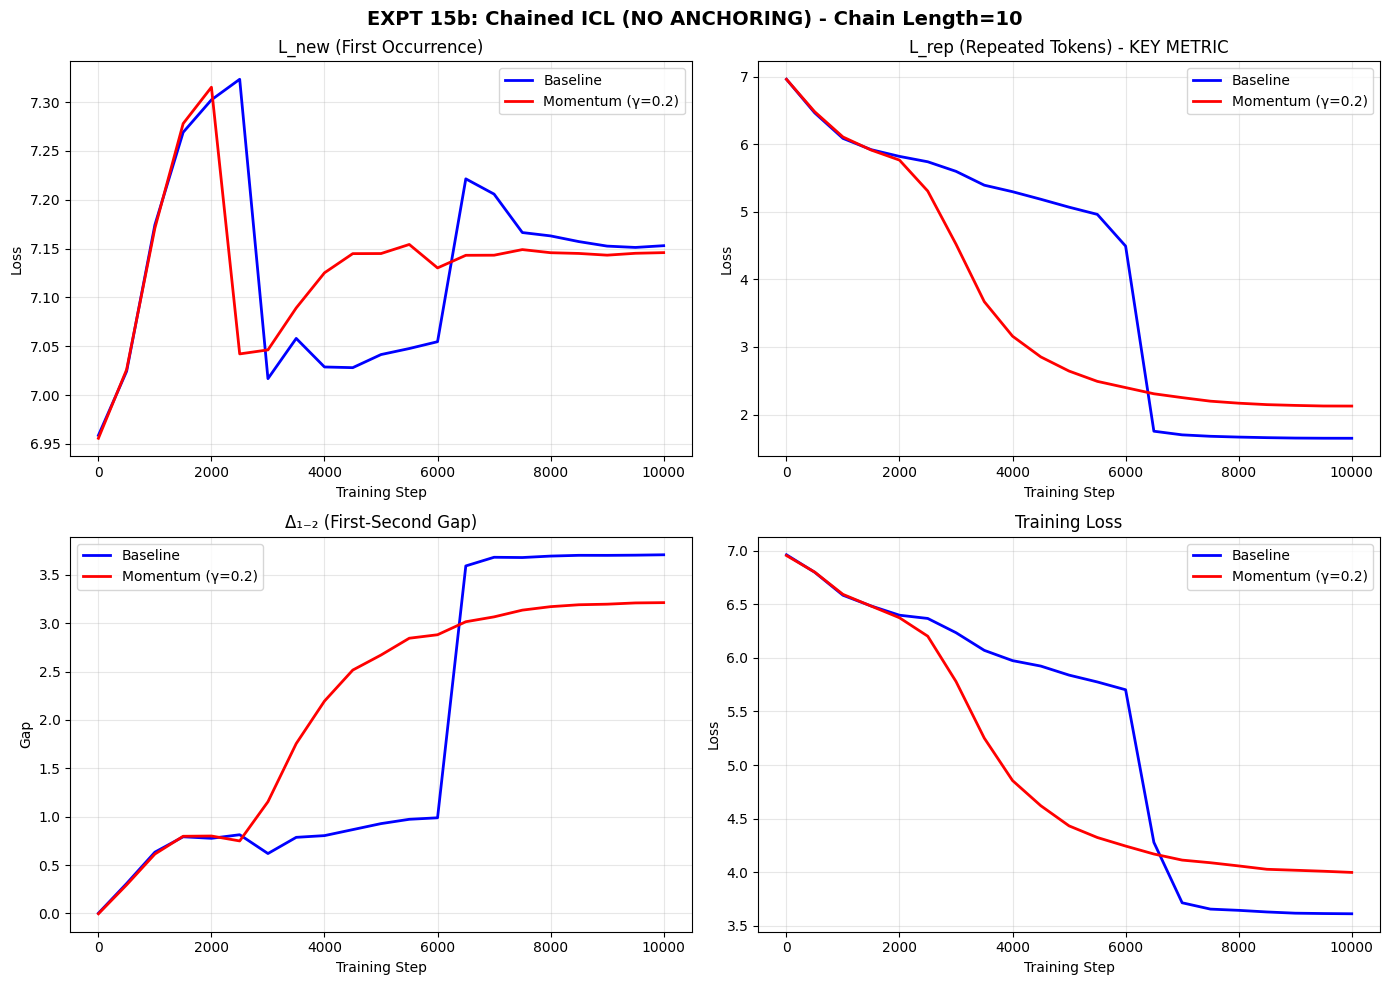

In [13]:
def plot_training_curves(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """Plot training curves comparing baseline and momentum."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    steps = history_baseline['step']

    # L_new
    ax = axes[0, 0]
    ax.plot(steps, history_baseline['L_new'], 'b-', label='Baseline', lw=2)
    ax.plot(steps, history_momentum['L_new'], 'r-', label=f'Momentum (γ={config.gamma})', lw=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')
    ax.set_title('L_new (First Occurrence)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # L_rep
    ax = axes[0, 1]
    ax.plot(steps, history_baseline['L_rep'], 'b-', label='Baseline', lw=2)
    ax.plot(steps, history_momentum['L_rep'], 'r-', label=f'Momentum (γ={config.gamma})', lw=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')
    ax.set_title('L_rep (Repeated Tokens) - KEY METRIC')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Δ₁₋₂
    ax = axes[1, 0]
    ax.plot(steps, history_baseline['delta_1_2'], 'b-', label='Baseline', lw=2)
    ax.plot(steps, history_momentum['delta_1_2'], 'r-', label=f'Momentum (γ={config.gamma})', lw=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Gap')
    ax.set_title('Δ₁₋₂ (First-Second Gap)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Training Loss
    ax = axes[1, 1]
    ax.plot(steps, history_baseline['train_loss'], 'b-', label='Baseline', lw=2)
    ax.plot(steps, history_momentum['train_loss'], 'r-', label=f'Momentum (γ={config.gamma})', lw=2)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'EXPT 15b: Chained ICL (NO ANCHORING) - Chain Length={config.chain_length}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'expt15b_training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return fig

fig_train = plot_training_curves(history_baseline, history_momentum, config)

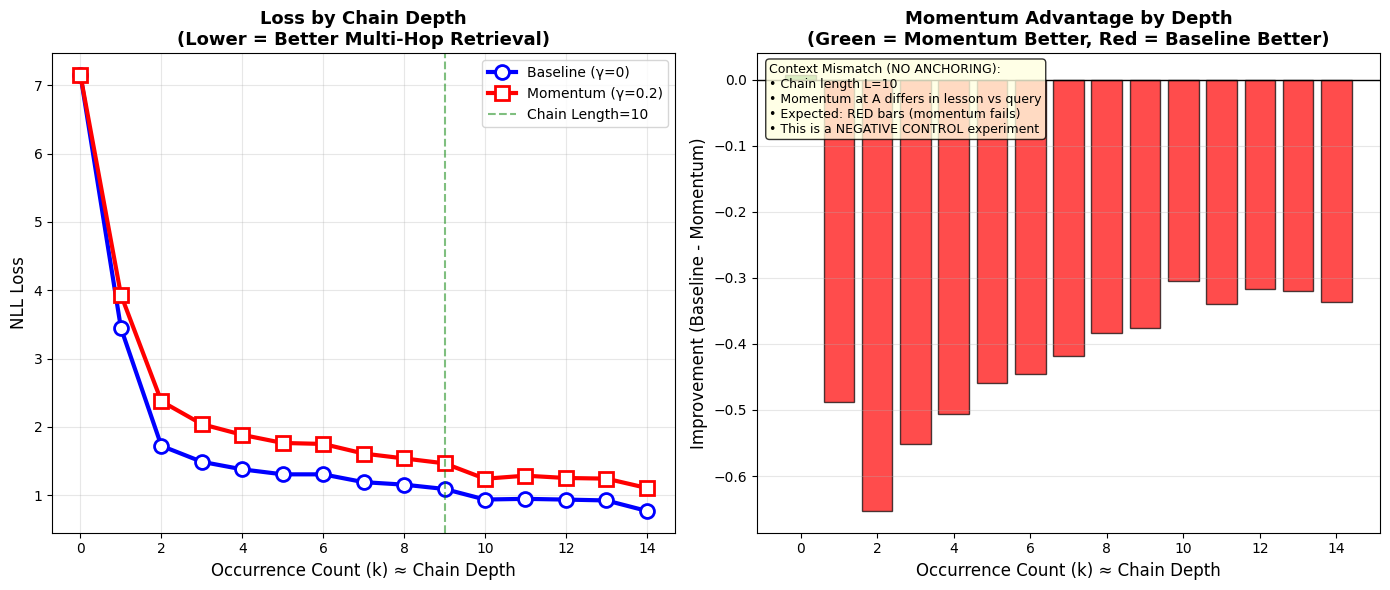


CHAIN DEPTH ANALYSIS (NO ANCHORING)
Depth    Baseline     Momentum     Δ (B-M)      Winner    
------------------------------------------------------------
0        7.1529       7.1458       +0.0071      Momentum  
1        3.4463       3.9337       -0.4874      Baseline  
2        1.7209       2.3737       -0.6528      Baseline  
3        1.4872       2.0387       -0.5515      Baseline  
4        1.3765       1.8821       -0.5056      Baseline  
5        1.3035       1.7631       -0.4596      Baseline  
6        1.3035       1.7487       -0.4452      Baseline  
7        1.1891       1.6079       -0.4188      Baseline  
8        1.1525       1.5365       -0.3839      Baseline  
9        1.0893       1.4648       -0.3754      Baseline  
10       0.9346       1.2390       -0.3044      Baseline  
11       0.9446       1.2841       -0.3395      Baseline  
12       0.9338       1.2500       -0.3162      Baseline  
13       0.9213       1.2408       -0.3196      Baseline  
14       0.7678  

In [14]:
def plot_chain_depth_analysis(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """
    THE KEY FIGURE: Loss by Chain Depth

    This shows the "exponential crash" hypothesis:
    - Baseline: Loss increases with depth (p^L decay)
    - Momentum (without anchoring): Expected to FAIL or show minimal improvement
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Get final occurrence losses
    occ_b = history_baseline['occurrence_losses'][-1]
    occ_m = history_momentum['occurrence_losses'][-1]

    ks = sorted([k for k in occ_b.keys() if not np.isnan(occ_b.get(k, float('nan')))])
    losses_b = [occ_b[k] for k in ks]
    losses_m = [occ_m[k] for k in ks]

    # Left: Absolute losses
    ax = axes[0]
    ax.plot(ks, losses_b, 'bo-', label='Baseline (γ=0)', lw=3, ms=10,
            markerfacecolor='white', markeredgewidth=2)
    ax.plot(ks, losses_m, 'rs-', label=f'Momentum (γ={config.gamma})', lw=3, ms=10,
            markerfacecolor='white', markeredgewidth=2)

    # Mark chain depth regions
    if config.chain_length <= len(ks):
        ax.axvline(x=config.chain_length-1, color='green', ls='--', alpha=0.5, label=f'Chain Length={config.chain_length}')

    ax.set_xlabel('Occurrence Count (k) ≈ Chain Depth', fontsize=12)
    ax.set_ylabel('NLL Loss', fontsize=12)
    ax.set_title('Loss by Chain Depth\n(Lower = Better Multi-Hop Retrieval)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    # Right: Improvement (Baseline - Momentum)
    ax = axes[1]
    improvement = [losses_b[i] - losses_m[i] for i in range(len(ks))]
    colors = ['green' if imp > 0 else 'red' for imp in improvement]
    ax.bar(ks, improvement, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', lw=1)

    ax.set_xlabel('Occurrence Count (k) ≈ Chain Depth', fontsize=12)
    ax.set_ylabel('Improvement (Baseline - Momentum)', fontsize=12)
    ax.set_title('Momentum Advantage by Depth\n(Green = Momentum Better, Red = Baseline Better)', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add theory box
    textstr = '\n'.join([
        'Context Mismatch (NO ANCHORING):',
        f'• Chain length L={config.chain_length}',
        '• Momentum at A differs in lesson vs query',
        '• Expected: RED bars (momentum fails)',
        '• This is a NEGATIVE CONTROL experiment',
    ])
    props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'expt15b_chain_depth.png'), dpi=150, bbox_inches='tight')
    plt.show()

    # Print numerical analysis
    print("\n" + "="*60)
    print("CHAIN DEPTH ANALYSIS (NO ANCHORING)")
    print("="*60)
    print(f"{'Depth':<8} {'Baseline':<12} {'Momentum':<12} {'Δ (B-M)':<12} {'Winner':<10}")
    print("-"*60)
    for i, k in enumerate(ks):
        diff = losses_b[i] - losses_m[i]
        winner = 'Momentum' if diff > 0 else 'Baseline'
        print(f"{k:<8} {losses_b[i]:<12.4f} {losses_m[i]:<12.4f} {diff:<+12.4f} {winner:<10}")

    # Summary statistics
    avg_improvement = np.mean(improvement)
    deep_improvement = np.mean(improvement[len(improvement)//2:]) if len(improvement) > 2 else avg_improvement
    print("-"*60)
    print(f"Average improvement: {avg_improvement:+.4f}")
    print(f"Deep links improvement (k>{len(ks)//2}): {deep_improvement:+.4f}")

    return fig

fig_depth = plot_chain_depth_analysis(history_baseline, history_momentum, config)

## 11. Statistical Summary

In [15]:
def print_summary(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """Print comprehensive summary for Chained ICL experiment (NO ANCHORING)."""
    print("="*70)
    print("EXPERIMENT 15b: CHAINED ICL RESULTS (NO ANCHORING - NEGATIVE CONTROL)")
    print("="*70)

    print(f"\nTask: Multi-Hop Retrieval (Chain Length L={config.chain_length})")
    print(f"Pattern: A→B→C→...→J (must predict next link from any position)")
    print(f"Momentum γ = {config.gamma}")
    print(f"⚠️ WARNING: NO ANCHOR TOKEN - Context mismatch expected!")

    print("\n" + "-"*70)
    print(f"{'Metric':<20} {'Baseline':<15} {'Momentum':<15} {'Δ (M-B)':<15}")
    print("-"*70)

    results = {}
    for name, key in [('L_new', 'L_new'), ('L_second', 'L_second'),
                      ('L_rep', 'L_rep'), ('Δ₁₋₂', 'delta_1_2')]:
        val_b = history_baseline[key][-1]
        val_m = history_momentum[key][-1]
        diff = val_m - val_b
        results[key] = {'baseline': float(val_b), 'momentum': float(val_m), 'diff': float(diff)}
        print(f"{name:<20} {val_b:<15.4f} {val_m:<15.4f} {diff:<+15.4f}")

    print("\n" + "="*70)
    print("HYPOTHESIS VALIDATION (Expected: FAIL due to no anchoring)")
    print("="*70)

    # H1: L_new similar
    l_new_pct = abs(results['L_new']['diff']) / results['L_new']['baseline'] * 100
    h1_pass = bool(l_new_pct < 15)
    print(f"\nH1: L_new unchanged (|Δ| < 15%)")
    print(f"    Result: |Δ| = {l_new_pct:.1f}% → {'✓ PASS' if h1_pass else '✗ FAIL'}")

    # H2: L_rep decreases
    l_rep_pct = results['L_rep']['diff'] / results['L_rep']['baseline'] * 100
    h2_pass = bool(results['L_rep']['diff'] < 0)
    print(f"\nH2: L_rep DECREASES (Δ < 0)")
    print(f"    Result: Δ = {results['L_rep']['diff']:.4f} ({l_rep_pct:.1f}%) → {'✓ PASS' if h2_pass else '✗ FAIL'}")

    # H3: Δ₁₋₂ increases
    h3_pass = bool(results['delta_1_2']['diff'] > 0)
    print(f"\nH3: Δ₁₋₂ INCREASES (Δ > 0)")
    print(f"    Result: Δ = {results['delta_1_2']['diff']:.4f} → {'✓ PASS' if h3_pass else '✗ FAIL'}")

    # H4: Deep links improvement (NEW for chained ICL)
    occ_b = history_baseline['occurrence_losses'][-1]
    occ_m = history_momentum['occurrence_losses'][-1]
    ks = sorted([k for k in occ_b.keys() if not np.isnan(occ_b.get(k, float('nan')))])

    if len(ks) > 4:
        deep_ks = ks[len(ks)//2:]
        deep_improvement = float(np.mean([occ_b[k] - occ_m[k] for k in deep_ks]))
        h4_pass = bool(deep_improvement > 0)
        print(f"\nH4: Deep links improvement (k>{len(ks)//2})")
        print(f"    Result: Avg improvement = {deep_improvement:.4f} → {'✓ PASS' if h4_pass else '✗ FAIL'}")
    else:
        h4_pass = False
        deep_improvement = 0.0
        print(f"\nH4: Deep links improvement")
        print(f"    Result: Insufficient chain depth for analysis")

    # Overall
    all_pass = h1_pass and h2_pass and h3_pass and h4_pass
    print("\n" + "="*70)
    if all_pass:
        print("🎉 ALL HYPOTHESES VALIDATED!")
        print(f"   Momentum rescues deep chain links (L={config.chain_length}).")
        print("   'Chain Reaction' hypothesis confirmed.")
    elif h2_pass or h3_pass:
        print("✓ PARTIAL SUCCESS")
        print("   Momentum shows some improvement on chained ICL.")
    else:
        print("⚠️ HYPOTHESES NOT VALIDATED (Expected for NO ANCHORING)")
        print("   This confirms the Context Mismatch problem.")
        print("   Without anchoring, momentum vectors differ between lesson and query.")
        print("   Compare with companion notebook WITH anchoring for proper results.")
    print("="*70)

    # Save - convert all numpy types to Python types for JSON serialization
    summary = {
        'experiment': 'expt15b_chained_icl_no_anchor',
        'task': 'multi_hop_retrieval',
        'anchoring': False,
        'chain_length': int(config.chain_length),
        'gamma': float(config.gamma),
        'results': results,
        'hypotheses': {
            'H1': h1_pass,
            'H2': h2_pass,
            'H3': h3_pass,
            'H4': h4_pass,
            'all_pass': all_pass
        },
        'deep_improvement': deep_improvement,
        'timestamp': datetime.now().isoformat(),
    }
    with open(os.path.join(config.save_dir, 'expt15b_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    return summary

summary = print_summary(history_baseline, history_momentum, config)

EXPERIMENT 15b: CHAINED ICL RESULTS (NO ANCHORING - NEGATIVE CONTROL)

Task: Multi-Hop Retrieval (Chain Length L=10)
Pattern: A→B→C→...→J (must predict next link from any position)
Momentum γ = 0.2
⚠️ WARNING: NO ANCHOR TOKEN - Context mismatch expected!

----------------------------------------------------------------------
Metric               Baseline        Momentum        Δ (M-B)        
----------------------------------------------------------------------
L_new                7.1529          7.1458          -0.0071        
L_second             3.4463          3.9337          +0.4874        
L_rep                1.6496          2.1261          +0.4765        
Δ₁₋₂                 3.7066          3.2121          -0.4946        

HYPOTHESIS VALIDATION (Expected: FAIL due to no anchoring)

H1: L_new unchanged (|Δ| < 15%)
    Result: |Δ| = 0.1% → ✓ PASS

H2: L_rep DECREASES (Δ < 0)
    Result: Δ = 0.4765 (28.9%) → ✗ FAIL

H3: Δ₁₋₂ INCREASES (Δ > 0)
    Result: Δ = -0.4946 → ✗ FAIL

H

## 12. Conclusions

This notebook demonstrates the **INCORRECT ANCHORING** case for chained ICL.

**Expected Result:** Momentum should FAIL or show minimal/negative improvement because:

1. **Context Mismatch Problem:**
   - Momentum at token A depends on the previous token
   - In the lesson: `p_A = A - (token_before_A_in_lesson)`
   - In the query: `p_A = A - (token_before_A_in_query)`
   - These are different → momentum vectors don't match → no guide-rail effect

2. **The Fix (see companion notebook):**
   - Use a special ANCHOR token (e.g., token 999) at the start of every chain
   - Chain format: `[ANCHOR] → A → B → C → ...`
   - Now momentum at A is always: `p_A = A - ANCHOR`
   - This is IDENTICAL in lesson and query → momentum works!

**Compare with:** `Appendix_N_correct_anchoring_ICL.ipynb`

In [16]:
print("\n" + "="*70)
print("EXPERIMENT COMPLETE")
print("="*70)
print(f"\nResults saved to: {config.save_dir}")
print(f"  - expt15b_training_curves.png")
print(f"  - expt15b_chain_depth.png")
print(f"  - expt15b_summary.json")
print(f"  - baseline_checkpoint.pt")
print(f"  - momentum_checkpoint.pt")
print("\n⚠️ This is the NO ANCHORING (negative control) notebook.")
print("   Compare results with the anchored version for proper analysis.")


EXPERIMENT COMPLETE

Results saved to: ./expt15b_results
  - expt15b_training_curves.png
  - expt15b_chain_depth.png
  - expt15b_summary.json
  - baseline_checkpoint.pt
  - momentum_checkpoint.pt

⚠️ This is the NO ANCHORING (negative control) notebook.
   Compare results with the anchored version for proper analysis.
